<a href="https://colab.research.google.com/github/arnauldnzegha/DEEP2PDEs/blob/main/Prevost__plant_growth_derivation_features_selection_with_Berg_Nystrom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Plant growth derivative observation and Features selection
In this notebook we observe the derivatives of the plant growth in time and space.

The gradient is computed on the Berg&Nystrom Model  https://www.sciencedirect.com/science/article/pii/S0021999119300944

# plants growth dataset : np.gradient (Prevost)

In [ ]:
import tensorflow as tf
from keras import backend as K 
from keras.models import Model
import math as M
import matplotlib.pyplot as plt
from keras.optimizers import SGD,Adadelta
from keras.layers import Dense, Input
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import scipy.io
from keras.regularizers import l1
from sklearn.neural_network import MLPRegressor
from random import shuffle
import time
from itertools import product
import zipfile, os
import cv2

from mpl_toolkits.mplot3d import axes3d, Axes3D


from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
import io
import base64


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
zip_id = '1jUqoXx-kBN59MWxvuq2ePX8i_vEpJtrr'
if not os.path.exists('data'): os.makedirs('data')
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('plantData.zip')
zip_ref = zipfile.ZipFile('plantData.zip', 'r')
zip_ref.extractall('data/')
zip_ref.close()

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
zip_id = '1oqKV2pGYfMrNbRkD2p69PfjusggNpexP'
weight = drive.CreateFile({'id': zip_id})
weight.GetContentFile('w_Prevost.h5')

In [ ]:
def get_data_plant_sliced_on_X(race=0, len_voxcel=20, translate=28, fact=10000):
    listeType=["Aubreville", "Corner", "Fagerlind", "Koriba", "Leeuwenberg", "Massart", "Nozeran", "Prevost", "Rauh", "Scarrone", "Troll"]
    dataP=[]
    data_dir="data/dbplantes"
    mod=listeType[race]
    ages=np.linspace(0.1, 10, 100)
    nb_r=np.arange(0,10)
    for t in ages:
      if(t%0.1!=0): t=(int(t*10))/10
      if(t%1==0): t=int(t)
      dataTP=[]
      for r in nb_r:
        filename =data_dir+"/mod_"+mod+"_"+str(t)+"_"+str(r)+".vxl"
        f = open(filename, "r")
        plant=np.zeros([56,56,40])
        ok=0
        for line in f:
          elts=line.split()
          if(ok<5):
            ok=ok+1
          else:
            vxl=[t,r,0,0,0,0]
            if(len(elts)>3):
              vxl[2],vxl[3],vxl[4],vxl[5]=float(elts[0]),float(elts[1]),float(elts[2]),float(elts[4])
              x,y,z=int(vxl[2]/len_voxcel)+translate, int(vxl[3]/len_voxcel)+translate, int(vxl[4]/len_voxcel)
              plant[x,y,z]=vxl[5]/fact
        dataTP.append(np.array(plant))
      dataP.append(np.array(dataTP))
    return np.array(dataP)

def plot_plan(plant, s=0, area=1):
  axe = slice_plant_mean(plant,s)
  colors =['g' for c in axe[2]]
  plt.scatter(axe[0],axe[1], s=axe[2]*area, c=colors, alpha=1)
  plt.xlabel('Y')
  plt.ylabel('Z')
  plt.show()

  
def plot_plan_in_line(plant, s=0, area=1,t=[20,50,90]):
  axe1 = slice_plant_mean(plant[t[0]],s)
  axe2 = slice_plant_mean(plant[t[1]],s)
  axe3 = slice_plant_mean(plant[t[2]],s)
  fig, (ax1, ax2,ax3) = plt.subplots(figsize=(13, 3), ncols=3)
  ax1.scatter(axe1[0],axe1[1], s=axe1[2]*area, c="g", alpha=1)
  ax2.scatter(axe2[0],axe2[1], s=axe2[2]*area, c="g", alpha=1)
  ax3.scatter(axe3[0],axe3[1], s=axe3[2]*area, c="g", alpha=1)
  ax1.set_title("2")
  ax2.set_title("5")
  ax3.set_title("9")
  plt.xlabel('Y')
  plt.ylabel('Z')
  plt.show()
  
  
def scat_plan(plant, s=0):
  axe = slice_plant_mean(plant,s)
  colors =['g' for c in axe[2]]
  fig = plt.figure()
  ax = Axes3D(fig)
  ax.scatter(axe[0],axe[1],axe[2], c='g', marker='.', alpha=1)
  ax.set_xlabel("Y")
  ax.set_ylabel("Z")
  ax.set_zlabel("U_y")
  plt.show()

def slice_plant_mean(plant, s=[0,5], proj=28):
  img=np.zeros(plant[0,:,:].shape)
  for x in range(s[0]+proj, s[1]+proj):
    img+=plant[x,:,:]
  nb=s[1]- s[0]
  img=img/nb
  return flatten_plan(img)

def slice_plant_mean2D(plant, s=[0,5], proj=28):
  img=np.zeros(plant[0,:,:].shape)
  for x in range(s[0]+proj, s[1]+proj):
    img+=plant[x,:,:]
  nb=s[1]- s[0]
  img=img/nb
  return img

def slice_plant_mean3D(plant, s=[0,5], proj=28):
  img=np.zeros(plant[:,0,:,:].shape)
  #plants2D=np.zeros(plant[0,:,:].shape)
  for x in range(s[0]+proj, s[1]+proj):
    img+=plant[:,x,:,:]
  nb=s[1]- s[0]
  img=img/nb
  return img

  
def flatten_plan(plant_part, proj=28):
  idm1 = np.where(plant_part > -1)
  return idm1[0]-proj,idm1[1], plant_part.flatten()

def flatten_plan0(plant_part):
  idm1 = np.where(plant_part > -10)
  return idm1[0],idm1[1], plant_part.flatten()

In [ ]:
!mkdir plot_pre
plot_root="plot_pre"
def plot_dymanics_plant(t,plant,s,title,area=20):
  if(s==0): axe = flatten_plan(plant[0],s)
  else: axe = slice_plant_mean(plant[0],s)
  fig = plt.figure()
  img=plt.scatter(axe[0],axe[1], s=axe[2]*area, c="g", alpha=1)
  plt.xlabel('Y')
  plt.ylabel('Z')
  def updatefig(i): 
    plt.title(title+" : t="+str(t[i]))
    img.set_offsets(list(zip(axe[0],axe[1])))
    if(s==0): img.set_sizes(flatten_plan(plant[i],s)[2]*area)
    else: img.set_sizes(slice_plant_mean(plant[i],s)[2]*area)
    return img,
  
  ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
  ani.save(plot_root+"/"+title+'.mp4', writer='ffmpeg', fps=10)

  
def plot_dymanics(t,x,y,u, title):
  xi,yi=np.meshgrid(x, y)
  fig = plt.figure()
  fig, (axes) = plt.subplots(figsize=(6, 5))
  rbf1 = scipy.interpolate.Rbf(xi, yi, u[0].T, function='linear')
  zi1 = rbf1(xi, yi)
  img = axes.imshow(zi1, cmap='binary', vmin=u.min(), vmax=u.max(),  origin='lower',
                    extent=[x.min(), x.max(), y.min(), y.max()], animated=True)
  plt.xlabel("x")
  plt.ylabel("y")
  plt.title(title+" : t="+str(t[0]))
  fig.colorbar(img, ax=axes)
  
  def updatefig(i):
    axes.set_title(title+" : t="+str(t[i]))
    img.set_array(u[i].T)
    return img,
  
  ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
  ani.save(plot_root+"/"+title+'.mp4', writer='ffmpeg', fps=10)

In [ ]:
def get_plant_mean_of_race(data):
  dataP=[]
  n_t,n_r=len(data),len(data[0])
  for t in range(n_t):
    plant_means=data[t,0]
    for r in range(1,n_r):
      plant_means=+data[t,r]
    plant_means/=n_r
    dataP.append(plant_means)
  return np.array(dataP)

In [ ]:
def get_sliced_part(data,s):
  x_train1, y_train1=[], []
  T=np.linspace(0.1, 10, 100)
  n_t,n_r=100,10
  To=9
  data=get_plant_mean_of_race(data)
  for t in range(n_t):
    y,z,biomas=slice_plant_mean(data[t],s)
    x_t=np.array(list(zip([T[t]]*len(y),y,z)))
    x_train1.extend(x_t)
    y_train1.extend(biomas)
  return np.array(x_train1), np.array(y_train1)

In [ ]:
def get_color(b,c="b",c1="red",c2="black"):
  co=[c for i in b]
  for i in range(len(b)):
    if(b[i]>0):
      co[i]=c1
    if(b[i]<0):
      co[i]=c2
  return co

In [ ]:
data =get_data_plant_sliced_on_X(race=7)
t,r=19,3
dataM=get_plant_mean_of_race(data)


In [ ]:
slice_x=[-2,2]
x_train, y_train=get_sliced_part(data,slice_x)
#x_train2, y_train2=x_train2[4000:], y_train2[4000:]
nb_neurons=20
L2_alpha=0.0#1e-6
tolerence=1e-34
max_itr=5000
Berg_Nystrom_skl_model_1_s2 = MLPRegressor(solver='lbfgs',activation='tanh', verbose=True, alpha=L2_alpha, tol=tolerence, hidden_layer_sizes=(nb_neurons, nb_neurons, nb_neurons, nb_neurons, nb_neurons, nb_neurons, nb_neurons), random_state=1, max_iter=max_itr)
Berg_Nystrom_skl_model_1_s2.fit(x_train, y_train)
print(Berg_Nystrom_skl_model_1_s2.score(x_train, y_train))

In [ ]:
def bio_driven_loss(yTrue,yPred):
  if (yTrue==0):
    return tf.reduce_mean(tf.square(1000*yPred))
  else:
    return tf.reduce_mean(tf.square(yPred - yTrue))

def berg_nystrom_model1():
    L1_PENALTY_TERM = 0.01
    nb_neurons = 20
    lr=0.01
    decay=1e-6
    momentum=0.9
    l1_reg = l1(L1_PENALTY_TERM)
    input_data = Input(shape=(3,))
    hidden1 = Dense(nb_neurons, activation = 'tanh', name = 'l1', kernel_regularizer = l1_reg)(input_data)
    hidden2 = Dense(nb_neurons, activation = 'tanh', name = 'l2', kernel_regularizer = l1_reg)(hidden1)
    hidden3 = Dense(nb_neurons, activation = 'tanh', name = 'l3', kernel_regularizer = l1_reg)(hidden2)
    hidden4 = Dense(nb_neurons, activation = 'tanh', name = 'l4', kernel_regularizer = l1_reg)(hidden3)
    hidden5 = Dense(nb_neurons, activation = 'tanh', name = 'l5', kernel_regularizer = l1_reg)(hidden4)
    hidden6 = Dense(nb_neurons, activation = 'tanh', name = 'l6', kernel_regularizer = l1_reg)(hidden5)
    hidden7 = Dense(nb_neurons, activation = 'tanh', name = 'l7', kernel_regularizer = l1_reg)(hidden6)
    output = Dense(1, activation = 'linear', name = 'out', kernel_regularizer = l1_reg)(hidden7)
    model = Model(input_data, output)
    sgd = SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
    model.compile(loss=bio_driven_loss, optimizer=sgd,  metrics=['accuracy'])
    return model

def transfert_sklearn_weights_to_keras(skl_model, keras_model):
  skl_layers=np.array(skl_model.coefs_) 
  skl_layers_bias=np.array(skl_model.intercepts_)
  nb_l=len(keras_model.layers)
  for i in range(1, nb_l):
    keras_model.layers[-i].set_weights([skl_layers[-i], skl_layers_bias[-i]])
  return keras_model

In [ ]:
model = berg_nystrom_model1()
hist=model.fit(np.array([[0,0,0]]),[0], validation_split=0.15, batch_size=1, epochs=1, verbose=0)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
model=transfert_sklearn_weights_to_keras(Berg_Nystrom_skl_model_1_s2, model)
from google.colab import files
model.save_weights('w_Prevost.h5')
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
uploaded = drive.CreateFile({'title': 'w_Prevost.h5'})
uploaded.SetContentFile('w_Prevost.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

## Gradients

In [ ]:
sess = tf.InteractiveSession()
w_file="w_Prevost.h5"
model = berg_nystrom_model1()
model.load_weights(w_file)

T=np.linspace(0.1, 10, 100)

grad_func = tf.gradients(model.output[:,0], model.input)
grad_func_second = tf.gradients(grad_func, model.input)
u_pred=model.predict(x_train)
u_pred=np.array(u_pred)
Uyzt_tf= sess.run(grad_func, feed_dict={model.input: x_train.reshape((-1, x_train[1].size))})[0]
Uyyzztt_tf = sess.run(grad_func_second, feed_dict={model.input: x_train.reshape((-1, x_train[1].size))})[0]
Ut_tf,Uy_tf,Uz_tf=zip(*Uyzt_tf)
Ut_tf,Uy_tf,Uz_tf=np.array(Ut_tf),np.array(Uy_tf), np.array(Uz_tf)
Utt_tf,Uyy_tf,Uzz_tf=zip(*Uyyzztt_tf)
Utt_tf,Uyy_tf,Uzz_tf=np.array(Utt_tf),np.array(Uyy_tf), np.array(Uzz_tf)

shap=dataM[:,2,:,:].shape
Ut_tf_=Ut_tf.reshape(shap)
Uy_tf_=Uy_tf.reshape(shap)
Uz_tf_=Uz_tf.reshape(shap)
Uyy_tf_=Uyy_tf.reshape(shap)
Uzz_tf_=Uzz_tf.reshape(shap)
u_pred_=u_pred.reshape(shap)
u_=y_train.reshape(shap)

Ux_xx_train_TF=[[u_pred[i], u_pred[i]*u_pred[i], u_pred[i]*u_pred[i]*u_pred[i],
                Uy_tf[i],Uz_tf[i],Uy_tf[i]*Uz_tf[i],Uyy_tf[i],Uzz_tf[i]] for i in range(0,len(Ut_tf))]


Ut_train_TF=Ut_tf
Ux_xx_train_TF=np.array(Ux_xx_train_TF)

In [ ]:
plant1=slice_plant_mean3D(dataM,[-2,2])
Utyz=np.gradient(plant1)
Utyz=np.array(Utyz)
print(Utyz.shape)
Uyzt_flatten=[]
u_f=plant1.flatten()

Ut_np,Uy_np,Uz_np=Utyz[0].flatten(),Utyz[1].flatten(),Utyz[2].flatten()
Uyy_np=np.gradient(Utyz[1])[1]
Uzz_np=np.gradient(Utyz[2])[2]
Uyy_np,Uzz_np=Uyy_np.flatten(), Uzz_np.flatten()

shap=dataM[:,2,:,:].shape
Ut_np_=Ut_np.reshape(shap)
Uy_np_=Uy_np.reshape(shap)
Uz_np_=Uz_np.reshape(shap)
Uyy_np_=Uyy_np.reshape(shap)
Uzz_np_=Uzz_np.reshape(shap)

Ux_xx_train_NP=[[u_f[i],u_f[i]*u_f[i],u_f[i]*u_f[i]*u_f[i],
                Uy_np[i],Uz_np[i],Uy_np[i]*Uz_np[i],Uyy_np[i],Uzz_np[i]] for i in range(0,len(Ut_np))]

Ut_train_NP=Ut_np
Ux_xx_train_NP=np.array(Ux_xx_train_NP)

(3, 100, 56, 40)


## plot

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


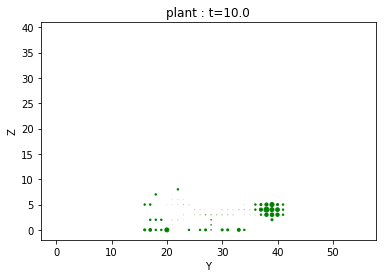

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


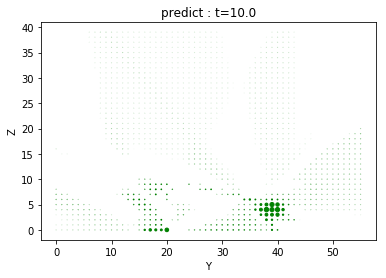

<Figure size 432x288 with 0 Axes>

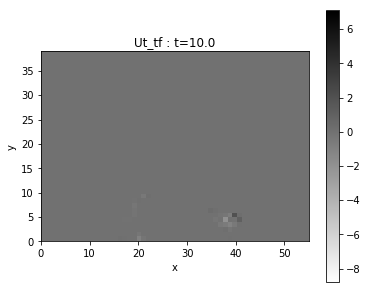

<Figure size 432x288 with 0 Axes>

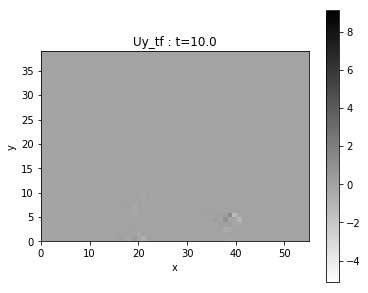

<Figure size 432x288 with 0 Axes>

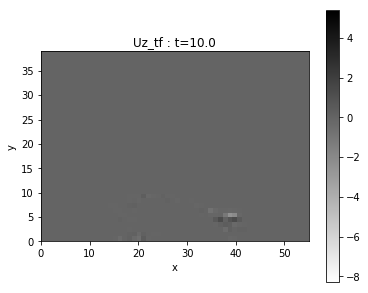

<Figure size 432x288 with 0 Axes>

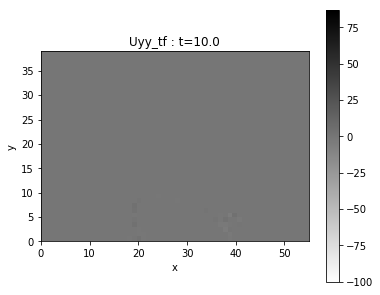

<Figure size 432x288 with 0 Axes>

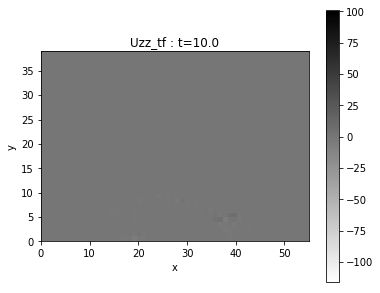

<Figure size 432x288 with 0 Axes>

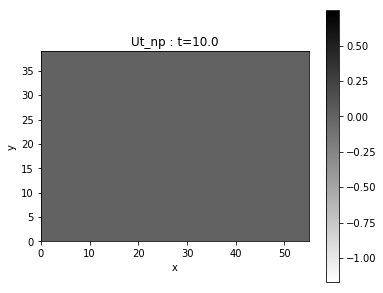

<Figure size 432x288 with 0 Axes>

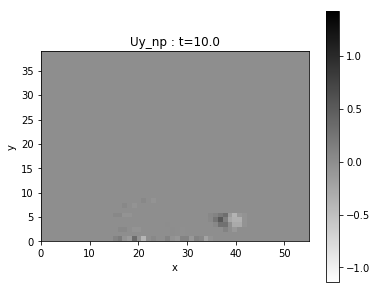

<Figure size 432x288 with 0 Axes>

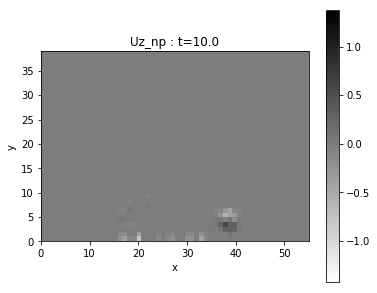

<Figure size 432x288 with 0 Axes>

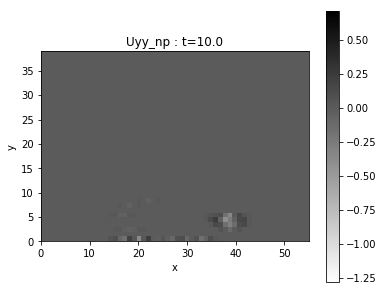

<Figure size 432x288 with 0 Axes>

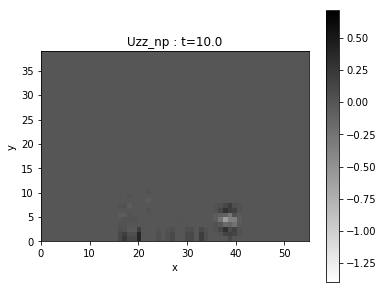

In [ ]:
T=np.linspace(0.1, 10, 100)
y,z=np.arange(56),np.arange(40)
plot_dymanics_plant(T,u_,0,"plant")
plot_dymanics_plant(T,u_pred_,0,"predict")

plot_dymanics(T,y,z,Ut_tf_,"Ut_tf")
plot_dymanics(T,y,z,Uy_tf_,"Uy_tf")
plot_dymanics(T,y,z,Uz_tf_,"Uz_tf")
plot_dymanics(T,y,z,Uyy_tf_,"Uyy_tf")
plot_dymanics(T,y,z,Uzz_tf_,"Uzz_tf")

plot_dymanics(T,y,z,Ut_np_,"Ut_np")
plot_dymanics(T,y,z,Uy_np_,"Uy_np")
plot_dymanics(T,y,z,Uz_np_,"Uz_np")
plot_dymanics(T,y,z,Uyy_np_,"Uyy_np")
plot_dymanics(T,y,z,Uzz_np_,"Uzz_np")


## gradients observation

In [ ]:
video = io.open(plot_root+'/predict.mp4', 'r+b').read()
video1 = io.open(plot_root+'/plant.mp4', 'r+b').read()
encoded = base64.b64encode(video)
encodedP = base64.b64encode(video1)

video1 = io.open(plot_root+'/Ut_tf.mp4', 'r+b').read()
video2 = io.open(plot_root+'/Ut_np.mp4', 'r+b').read()
encodedT1 = base64.b64encode(video1)
encodedT2 = base64.b64encode(video2)

video1 = io.open(plot_root+'/Uy_tf.mp4', 'r+b').read()
video2 = io.open(plot_root+'/Uy_np.mp4', 'r+b').read()
encodedX1 = base64.b64encode(video1)
encodedX2 = base64.b64encode(video2)

video1 = io.open(plot_root+'/Uz_tf.mp4', 'r+b').read()
video2 = io.open(plot_root+'/Uz_np.mp4', 'r+b').read()
encodedY1 = base64.b64encode(video1)
encodedY2 = base64.b64encode(video2)

video1 = io.open(plot_root+'/Uyy_tf.mp4', 'r+b').read()
video2 = io.open(plot_root+'/Uyy_np.mp4', 'r+b').read()
encodedXX1 = base64.b64encode(video1)
encodedXX2 = base64.b64encode(video2)

video1 = io.open(plot_root+'/Uzz_tf.mp4', 'r+b').read()
video2 = io.open(plot_root+'/Uzz_np.mp4', 'r+b').read()
encodedYY1 = base64.b64encode(video1)
encodedYY2 = base64.b64encode(video2)

HTML(data='''<h2>Gradient comparison</h2>
             <table>
             <tr><td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video></td>
             <td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{1}" type="video/mp4" />
             </video></td></tr>
             <table>
             
             
             <table>
             <tr><td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{2}" type="video/mp4" />
             </video></td>
             <td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{3}" type="video/mp4" />
             </video></td></tr>
             <table>
             
             
             <table>
             <tr><td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{4}" type="video/mp4" />
             </video></td>
             <td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{5}" type="video/mp4" />
             </video></td></tr>
             <table>
             
             
             <table>
             <tr><td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{6}" type="video/mp4" />
             </video></td>
             <td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{7}" type="video/mp4" />
             </video></td></tr>
             <table>
             
             
             <table>
             <tr><td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{8}" type="video/mp4" />
             </video></td>
             <td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{9}" type="video/mp4" />
             </video></td></tr>
             <table>
             
             
             <table>
             <tr><td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{8}" type="video/mp4" />
             </video></td>
             <td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{9}" type="video/mp4" />
             </video></td></tr>
             <table>
             
             <br/>
             '''.format(encoded.decode('ascii'),encodedP.decode('ascii'),
                       encodedT1.decode('ascii'),encodedT2.decode('ascii'),
                       encodedX1.decode('ascii'),encodedX2.decode('ascii'),
                       encodedXX1.decode('ascii'),encodedXX2.decode('ascii'),
                       encodedY1.decode('ascii'),encodedY2.decode('ascii'),
                       encodedYY1.decode('ascii'),encodedYY2.decode('ascii')))

## Feature

### routines

In [ ]:
def plot_variance(Ux_xx_trainFS):
  var_x=np.var(Ux_xx_trainFS, axis=0)
  var_x=[np.sum(x) for x in var_x]
  rang=sorted(zip(map(lambda x: round(x, 7), var_x), names), reverse=True)
  print(rang)
  rang,labels=zip(*list(rang))
  fig= plt.figure(figsize=(12,6))
  axes= fig.add_axes([0.1,0.1,0.8,0.8])
  axes.bar(np.arange(len(var_x))*2, rang, tick_label=labels)
  plt.show()

In [ ]:
def RLasso_plote(Ux_xx_trainFS,Ut_train):
  X_train,X_test,y_train,y_test=train_test_split(Ux_xx_trainFS, Ut_train, test_size=0.3, random_state=31)
  
  alphas=[1,0.1, 0.01,0.001, 0.0001, 0.00001,0.000001,0.00000001,0]
  error=[]
  for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10e3)
    lasso.fit(X_train,y_train)
    train_score=lasso.score(X_train,y_train)
    test_score=lasso.score(X_test,y_test)
    coeff_used = np.sum(lasso.coef_!=0)
    error.append([alpha,train_score,test_score])
    print("*********************alpha= ",alpha,"********************************")
    print ("training score :", train_score)
    print ("test score : ", test_score)
    print ("number of features used :", coeff_used)
    print(lasso.coef_)
    
    fig= plt.figure(figsize=(12,6))
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    axes.bar(np.arange(len(lasso.coef_))*2,np.fabs(lasso.coef_),tick_label=names)
    plt.show()
  error=np.array(error)

In [ ]:
def RFE_plote(Ux_xx_trainFS,Ut_train):
  from sklearn.feature_selection import RFE
  from sklearn.linear_model import LinearRegression
  X_train,X_test,y_train,y_test=train_test_split(Ux_xx_trainFS, Ut_train, test_size=0.3, random_state=31)

  lr = LinearRegression()
  rfe = RFE(lr, n_features_to_select=5)
  rfe.fit(Ux_xx_trainFS, Ut_train)

  lr_train_score=rfe.score(X_train,y_train)
  lr_test_score=rfe.score(X_test,y_test)
  
  rang=sorted(zip(map(lambda x: round(x, 7), rfe.ranking_), names))
  print(rfe.estimator_.coef_)
  #rang=list(zip(np.fabs(rfe.ranking_), names))
  #rang=sorted(rang,key=lambda l:l[0])
  rang,labels=zip(*list(rang))
  fig= plt.figure(figsize=(12,6))
  axes= fig.add_axes([0.1,0.1,0.8,0.8])
  axes.bar(np.arange(len(rfe.ranking_))*2,rang,tick_label=labels)
  plt.show()
  
  print ("LR training score:", lr_train_score)
  print ("LR test score: ", lr_test_score)

### Variance

TF.GRAD
[(0.8596474, 'Uyy'), (0.4591763, 'Uxx'), (0.0687944, 'Ux*Uy'), (0.0323696, 'U^3'), (0.0160358, 'Uy'), (0.0073129, 'U^2'), (0.0064626, 'Ux'), (0.0037179, 'U')]


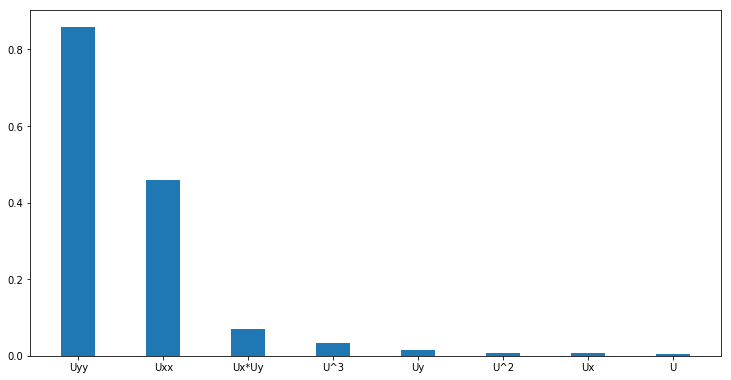

NP.GRAD
[(0.034944, 'U^3'), (0.0081189, 'U^2'), (0.0040324, 'U'), (0.0017256, 'Uy'), (0.0013712, 'Ux'), (0.0012362, 'Uyy'), (0.0008852, 'Uxx'), (0.0001353, 'Ux*Uy')]


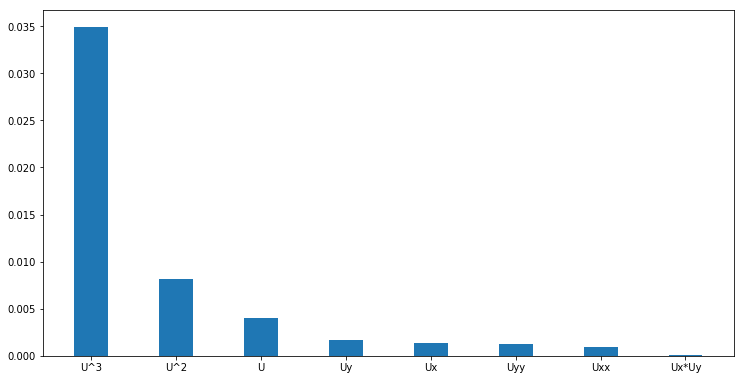

In [ ]:
names = ["U","U^2","U^3","Ux","Uy","Ux*Uy","Uxx","Uyy"]
print("TF.GRAD")
plot_variance(Ux_xx_train_TF)
print("NP.GRAD")
plot_variance(Ux_xx_train_NP)

### RFE

TF.GRAD
[ 0.20341881 -0.29233371  0.08428542 -0.3909336  -0.07498999]


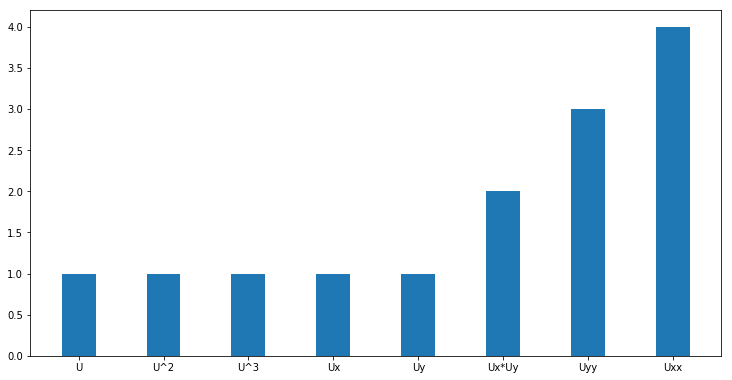

LR training score: 0.12230341502746246
LR test score:  0.13043318807597926
*****************************************************************
NP.GRAD
[ 0.00462053 -0.00143859 -0.05534772 -0.03337275  0.00411497]


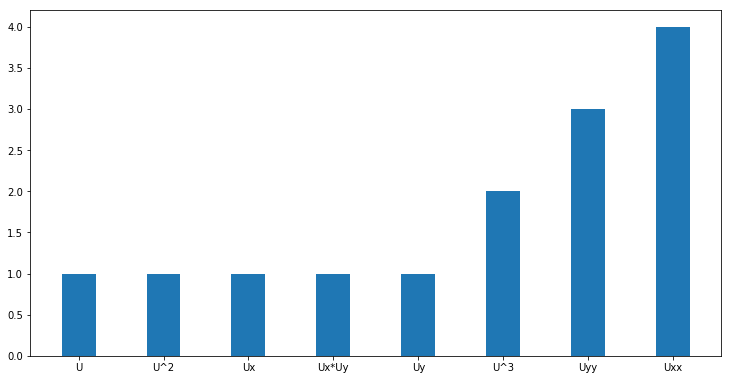

LR training score: 0.029168840289713116
LR test score:  0.04974112081425508


In [ ]:
print("TF.GRAD")
RFE_plote(Ux_xx_train_TF,Ut_tf)
print("*****************************************************************")
print("NP.GRAD")
RFE_plote(Ux_xx_train_NP,Ut_np)

### R-lasso

TF.GRAD
*********************alpha=  1 ********************************
training score : -6.7537153647379e-10
test score :  -4.877714314677206e-06
number of features used : 0
[ 0.  0.  0. -0. -0.  0. -0.  0.]


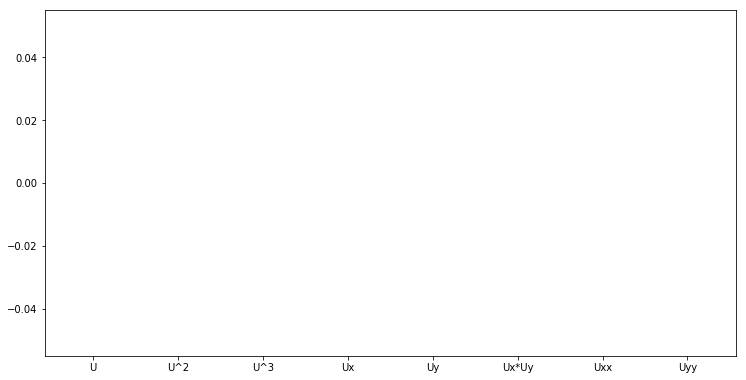

*********************alpha=  0.1 ********************************
training score : -6.7537153647379e-10
test score :  -4.877714314677206e-06
number of features used : 0
[ 0.  0.  0. -0. -0.  0. -0.  0.]


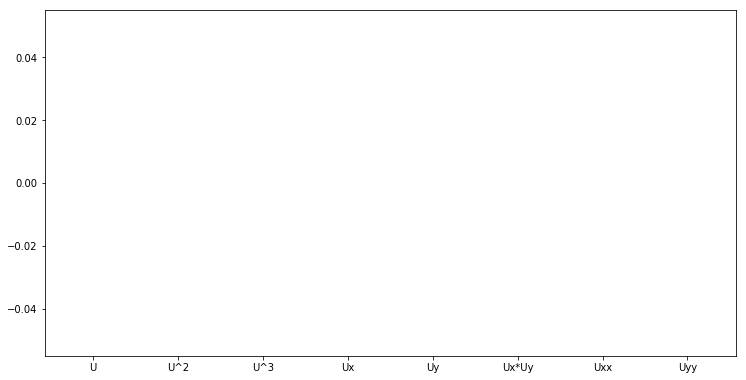

*********************alpha=  0.01 ********************************
training score : 0.01700544337375709
test score :  -0.003996057015979604
number of features used : 1
[ 0.          0.          0.         -0.         -0.          0.
 -0.          0.00526099]


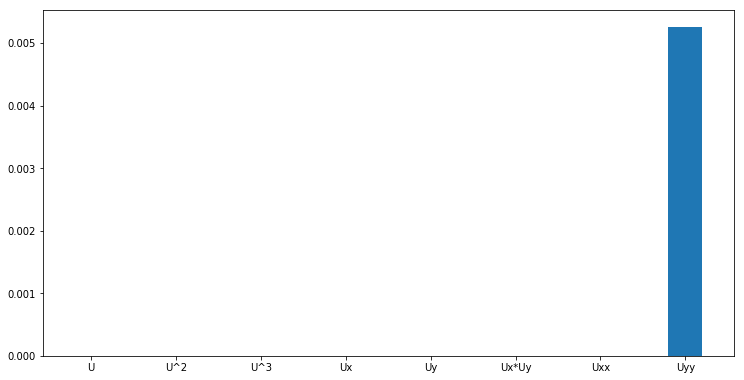

*********************alpha=  0.001 ********************************
training score : 0.12809519908853362
test score :  0.07347278234224786
number of features used : 4
[ 0.          0.          0.         -0.16169998 -0.          0.03907805
 -0.00141884  0.01371394]


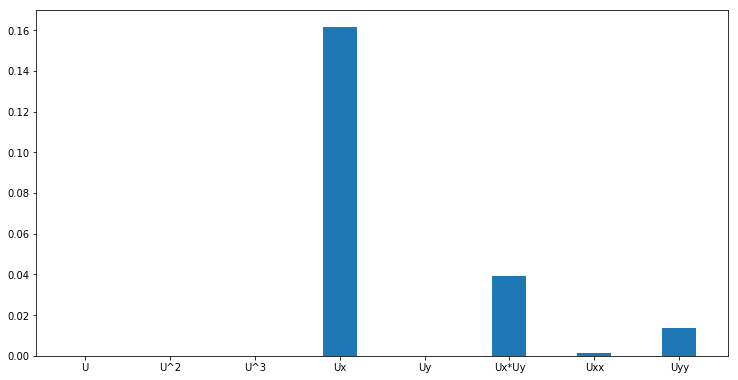

*********************alpha=  0.0001 ********************************
training score : 0.15817286361491023
test score :  0.10650306075223183
number of features used : 6
[ 0.00000000e+00  0.00000000e+00  1.55225805e-02 -3.11224295e-01
 -5.16987983e-02  4.16118740e-02 -2.75960734e-04  1.38596755e-02]


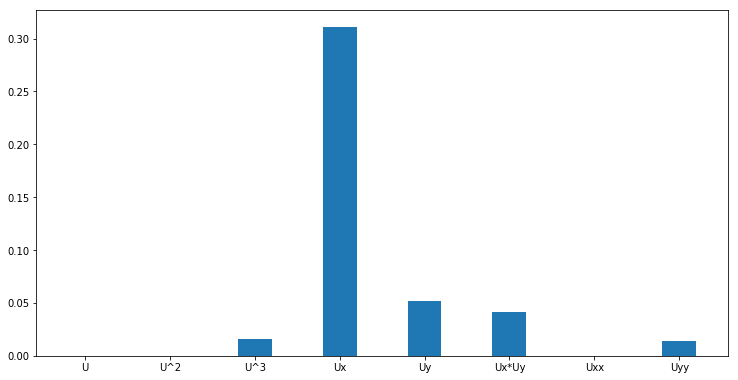

*********************alpha=  1e-05 ********************************
training score : 0.15942371291853907
test score :  0.10726516190036273
number of features used : 8
[ 7.63308233e-02 -1.27648265e-01  5.74790166e-02 -3.26539952e-01
 -5.85512918e-02  4.19248427e-02 -3.16116405e-04  1.37314713e-02]


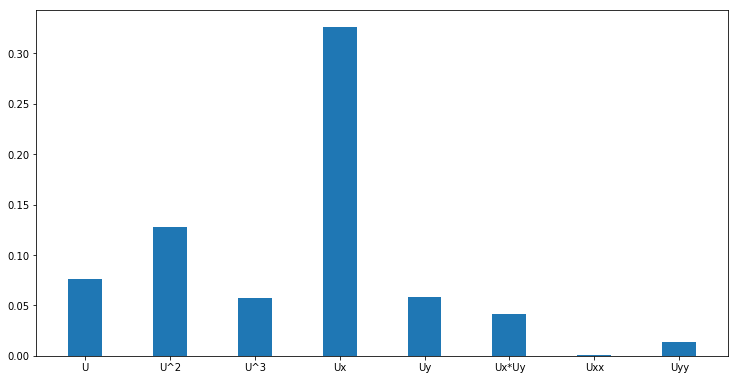

*********************alpha=  1e-06 ********************************
training score : 0.15983909891190318
test score :  0.10669449076895687
number of features used : 8
[ 0.16417975 -0.27428679  0.1029665  -0.32857612 -0.06001553  0.04197427
 -0.00050101  0.01353642]


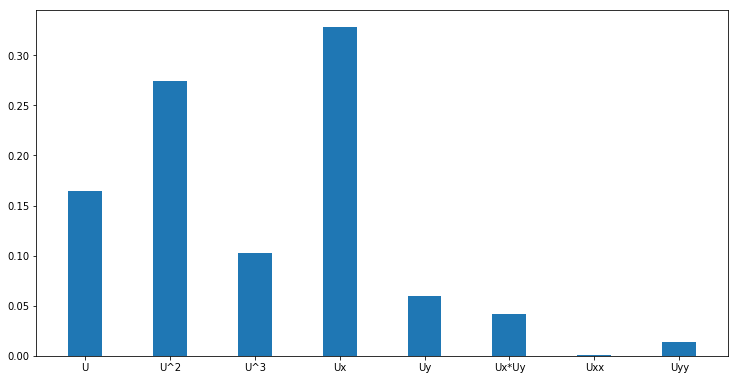

*********************alpha=  1e-08 ********************************
training score : 0.1598432984508129
test score :  0.10660193832066855
number of features used : 8
[ 0.1738484  -0.29042586  0.10797286 -0.32880014 -0.06017665  0.04197971
 -0.00052136  0.01351496]


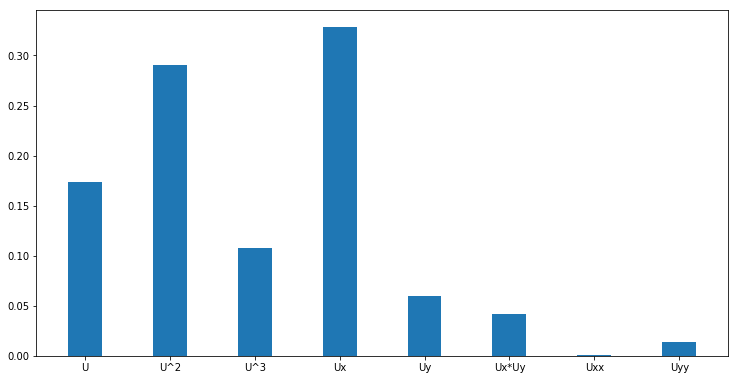

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 499.26659736345937, tolerance: 0.11885082795379172
  positive)


*********************alpha=  0 ********************************
training score : 0.15984329887081483
test score :  0.10660097335553287
number of features used : 8
[ 0.17394606 -0.29058888  0.10802343 -0.3288024  -0.06017827  0.04197976
 -0.00052157  0.01351474]


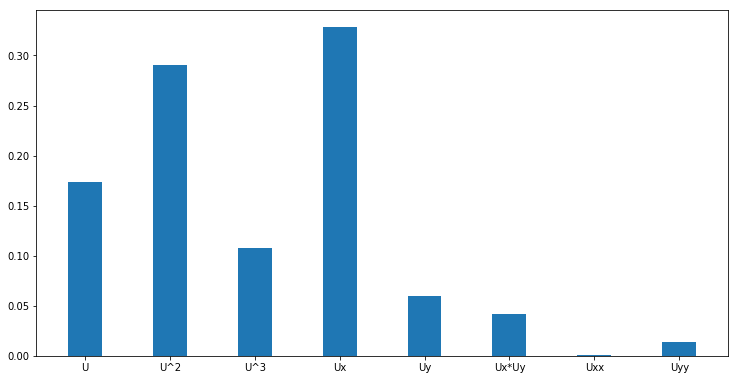

In [ ]:
print('TF.GRAD')
RLasso_plote(Ux_xx_train_TF,Ut_tf)

NP.GRAD
*********************alpha=  1 ********************************
training score : 0.0
test score :  -3.6096608525992835e-05
number of features used : 0
[-0.  0.  0. -0. -0. -0.  0.  0.]


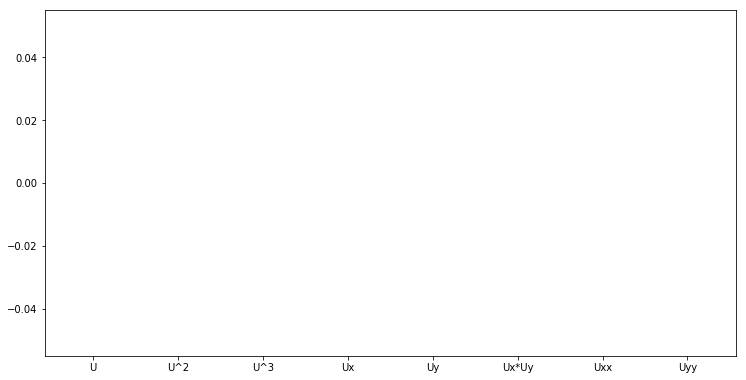

*********************alpha=  0.1 ********************************
training score : 0.0
test score :  -3.6096608525992835e-05
number of features used : 0
[-0.  0.  0. -0. -0. -0.  0.  0.]


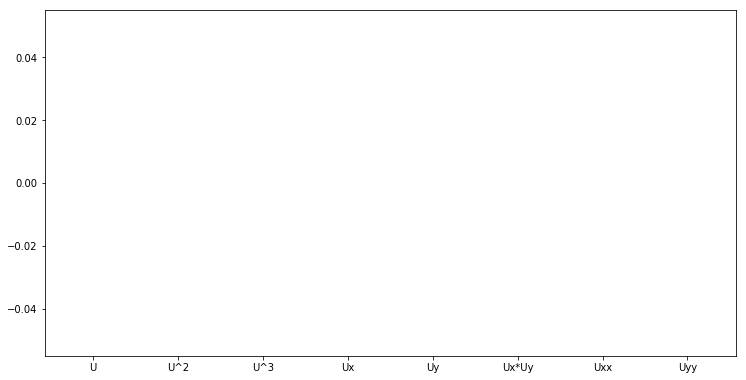

*********************alpha=  0.01 ********************************
training score : 0.0
test score :  -3.6096608525992835e-05
number of features used : 0
[-0.  0.  0. -0. -0. -0.  0.  0.]


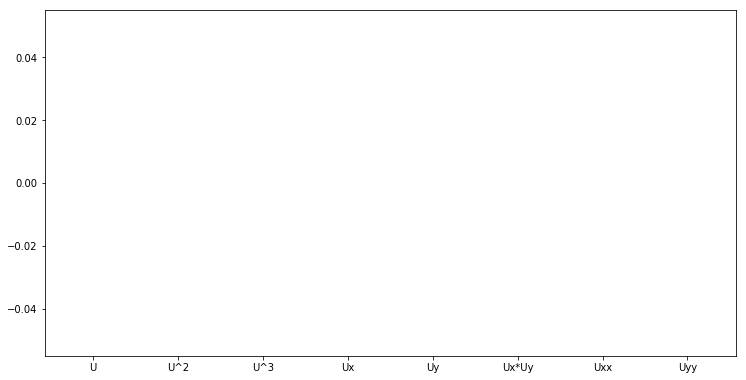

*********************alpha=  0.001 ********************************
training score : 0.0
test score :  -3.6096608525992835e-05
number of features used : 0
[-0.  0.  0. -0. -0. -0.  0.  0.]


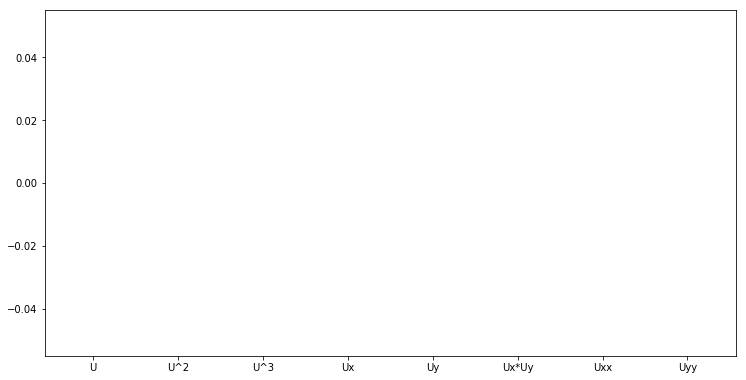

*********************alpha=  0.0001 ********************************
training score : 0.0
test score :  -3.6096608525992835e-05
number of features used : 0
[-0.  0.  0. -0. -0. -0.  0.  0.]


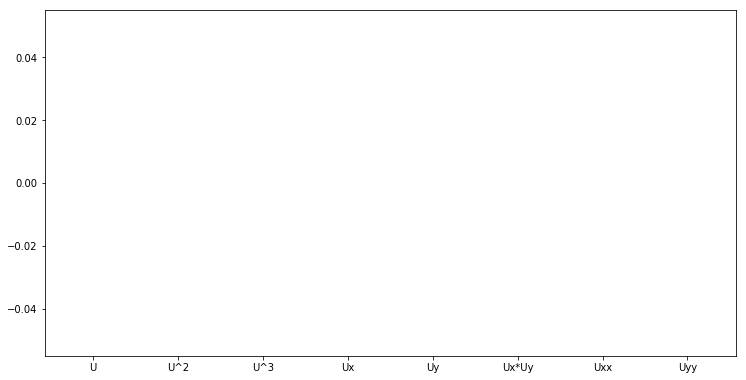

*********************alpha=  1e-05 ********************************
training score : 0.03089710650914967
test score :  0.03766796400851613
number of features used : 4
[-0.00024967 -0.          0.00126183 -0.03644508 -0.0322435  -0.
  0.          0.        ]


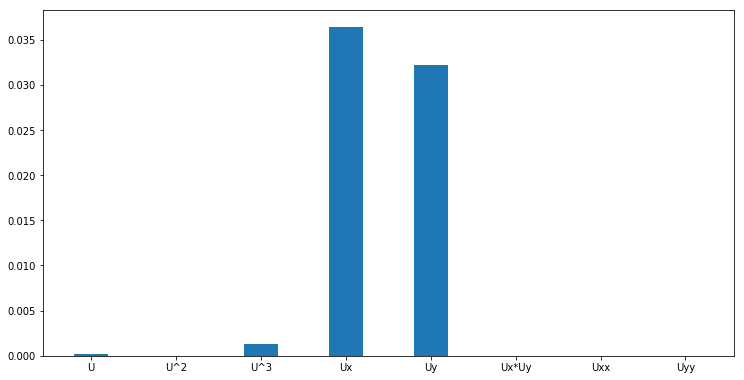

*********************alpha=  1e-06 ********************************
training score : 0.03348328510002252
test score :  0.03328102321961324
number of features used : 6
[ 0.01145646 -0.02989675  0.01237939 -0.04309136 -0.03687227 -0.01404946
  0.         -0.        ]


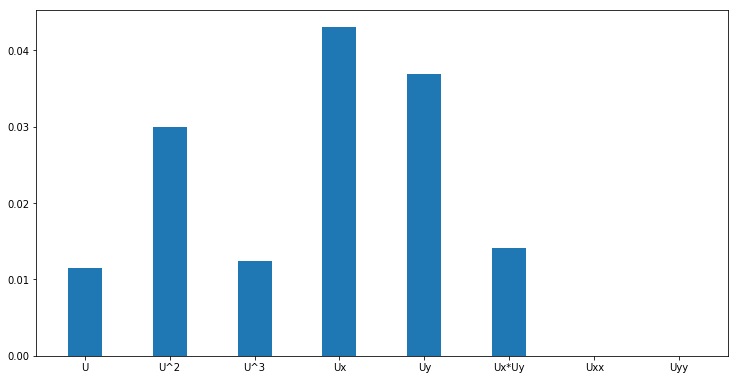

*********************alpha=  1e-08 ********************************
training score : 0.03371579470922348
test score :  0.03129258796472101
number of features used : 8
[ 2.15213006e-02 -4.66607361e-02  1.76372644e-02 -4.39988559e-02
 -3.74854825e-02 -2.14731191e-02 -2.90819869e-06 -7.46560197e-04]


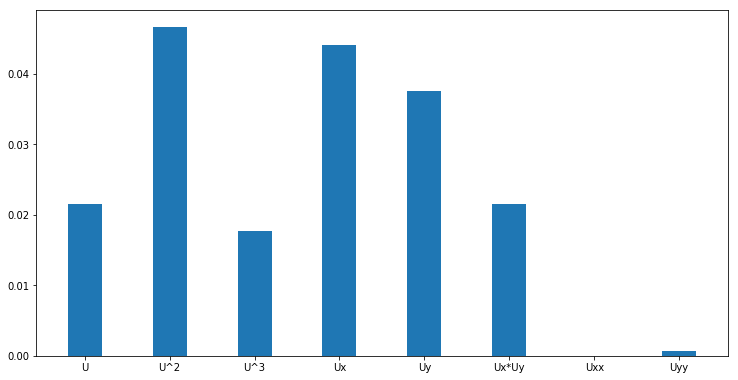

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.641432759345303, tolerance: 0.0028234825892648565
  positive)


*********************alpha=  0 ********************************
training score : 0.03371582235279147
test score :  0.03127139400988854
number of features used : 8
[ 2.16202569e-02 -4.68540493e-02  1.76964967e-02 -4.40069351e-02
 -3.74929269e-02 -2.15390596e-02 -4.07094584e-05 -7.70328255e-04]


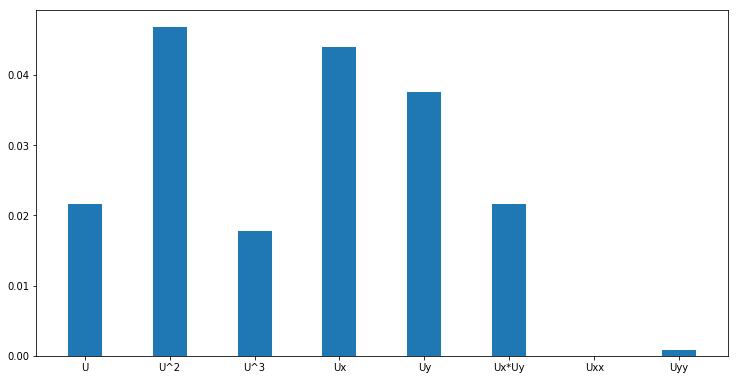

In [ ]:
print('NP.GRAD')
RLasso_plote(Ux_xx_train_NP,Ut_np)

#TEST

In [ ]:
Ux_xx_train_TF=[[u_pred[i], u_pred[i]*u_pred[i], u_pred[i]*u_pred[i]*u_pred[i],
                Uy_tf[i],Uz_tf[i],Uy_tf[i]*Uz_tf[i]] for i in range(0,len(Ut_tf))]


Ut_train_TF=Ut_tf
Ux_xx_train_TF=np.array(Ux_xx_train_TF)

In [ ]:
 Berg_Nystrom_skl_model_2= MLPRegressor(solver='lbfgs',alpha=1e-7, tol=1e-51, hidden_layer_sizes=(), random_state=1, max_iter=1000)
 Berg_Nystrom_skl_model_2.fit(Ux_xx_train_TF, Ut_train_TF)

In [ ]:
print(Berg_Nystrom_skl_model_2.coefs_)